In [1]:
import numpy
import cv2

In [2]:
import random

In [3]:
import matplotlib.pyplot as plt

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

In [5]:
import torch
from torch import nn

In [6]:
from fastai.vision.all import *

In [7]:
class custom_dataset(Dataset):
    def __init__(self,n):
        self.n = n
        pass
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        img = numpy.zeros((300,300,3))
        nc_rgb = {0:0,1:0,2:0}
        for nc in range(random.randint(5,14)):
            cx = random.randint(30,270)
            cy = random.randint(30,270)
            center_coordinates = (cx, cy)
            radius = random.randint(5,20)
            # color in RGB
            color = [0,0,0]
            color_idx = random.randint(0,2)
            color[color_idx] = 1
            nc_rgb[color_idx] += 1
            thickness = -1
            image = cv2.circle(img, center_coordinates, radius, color, thickness)
        image = torch.Tensor(image).permute(2,1,0)
        return image, torch.tensor([nc_rgb[k] for k in range(0,3)],dtype=torch.float32)

In [8]:
batch_size = 128

In [9]:
train_dataloader = DataLoader(custom_dataset(8196), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(custom_dataset(1024), batch_size=batch_size, shuffle=True)

In [10]:
def show_batch(train_features, train_labels):
    figure = plt.figure(figsize=(7, 7))
    cols, rows = 3,3
    for i in range(1, cols * rows + 1):
        label =  train_labels[i]
        img, img_mt = train_features[0][i], train_features[1][i]
        figure.add_subplot(rows, cols, i)
        plt.title(f"{label.item():.2f}, {img_mt}")
        plt.axis("off")
        plt.imshow(img.permute(2,1,0))
    plt.show()

In [11]:
class custom_model(nn.Module):
    def __init__(self):
        super(custom_model, self).__init__()
        self.conv_layers = nn.Sequential(
        nn.Conv2d(3, 8, 3),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Conv2d(8, 16, 3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 32, 3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, 3, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, 3, stride=2),
        nn.ReLU(),
        )
        self.linear = nn.Linear(9248,3,bias=True)
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.shape[0],-1)
        x = self.linear(x)
        return x

In [24]:
def show_preds(train_features, pred_labels, exp_labels ):
    figure = plt.figure(figsize=(14, 14))
    cols, rows = 3,3
    for i in range(1, cols * rows + 1):
        label =  pred_labels[i]
        img = train_features[i]
        figure.add_subplot(rows, cols, i)
        plt.title(f"{[round(i,2) for i in label.tolist()]}, exp:{exp_labels[i].tolist()}")
        plt.axis("off")
        plt.imshow(img.permute(2,1,0))
    plt.show()

### Fastai learner class 

In [19]:
data = DataLoaders(train_dataloader, test_dataloader, device='cpu')

In [20]:
learn = Learner(data, custom_model(), loss_func=F.mse_loss, opt_func=Adam)

In [17]:
learn.lr_find()

KeyboardInterrupt: 

In [16]:
learn.fit_one_cycle(15, 1e-3)

epoch,train_loss,valid_loss,time
0,4.467549,4.369985,00:26
1,2.606616,2.225958,00:26
2,1.274902,3.057298,00:26
3,0.712801,24.243729,00:26
4,0.467339,6.828402,00:26
5,0.399227,2.050098,00:26
6,0.361550,6.040743,00:26
7,0.306425,0.880775,00:26
8,0.263073,0.219279,00:26
9,0.255709,0.227357,00:27


In [26]:
learn = learn.load('nn_metadata_fai_model_8k.pth')

In [17]:
learn.save('nn_metadata_fai_model_8k.pth')

Path('models/nn_metadata_fai_model_8k.pth.pth')

In [16]:
test_features, test_labels = next(iter(test_dataloader))

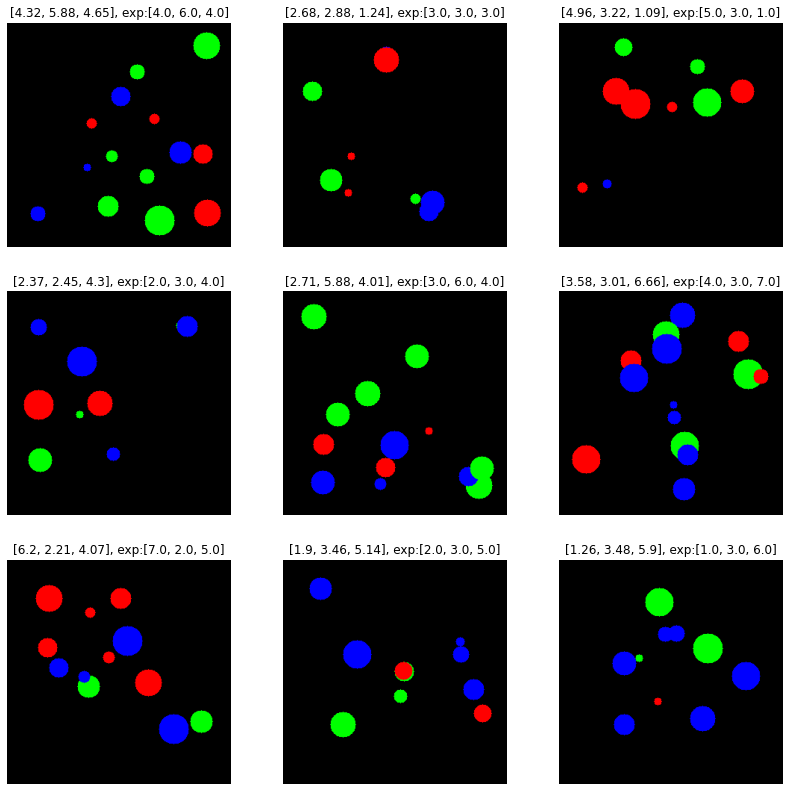

In [27]:
show_preds(test_features, learn.model(test_features.cpu()),test_labels.cpu())